Importing

In [1]:
import os
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
train_dir = r'C:\Users\Gnana chandrika\Downloads\Dataset-DL\vitamins_detection'
test_dir = r'C:\Users\Gnana chandrika\Downloads\Dataset-DL\test_data' 

Image PreProcessing 

In [3]:
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8968 images belonging to 5 classes.
Found 224 images belonging to 5 classes.


Model Building

In [4]:
# # Inputs
input_tensor = Input(shape=(img_height, img_width, 3))

# # VGG16 Model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg16_out = GlobalAveragePooling2D()(vgg16_base.output)

# # ResNet50 Model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet50_out = GlobalAveragePooling2D()(resnet50_base.output)

# # Concatenating outputs
combined = Concatenate()([vgg16_out, resnet50_out])

# # Fully Connected Layers
x = Dense(1024, activation='relu')(combined)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

# # Creating the model
model = Model(inputs=input_tensor, outputs=predictions)

# # Freezing layers of base models
for layer in vgg16_base.layers[:15]:  # Freeze first 15 layers of VGG16
    layer.trainable = False

for layer in resnet50_base.layers[:15]:  # Freeze first 15 layers of ResNet50
    layer.trainable = False


Compiling the Model

In [5]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# # Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg_resnet.keras', monitor='val_loss', save_best_only=True)

Training the Model

In [6]:
# # Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 1790s 6s/step - accuracy: 0.5359 - loss: 1.1938 - val_accuracy: 0.1339 - val_loss: 1.8489
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 832us/step - accuracy: 0.7500 - loss: 0.7754
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 1818s 6s/step - accuracy: 0.7633 - loss: 0.6494 - val_accuracy: 0.2500 - val_loss: 2.1101
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 188us/step - accuracy: 0.6875 - loss: 0.7623
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 1717s 6s/step - accuracy: 0.8048 - loss: 0.5298 - val_accuracy: 0.6473 - val_loss: 1.1013
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 141us/step - accuracy: 0.7812 - loss: 0.5300
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 2106s 8s/step - accuracy: 0.8366 - loss: 0.4373 - val_accuracy: 0.8571 - val_loss: 0.4763
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 290us/step - accuracy: 0.8125 - loss: 0.5518
Epoch 9/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 2462s 9s/step - accuracy: 0.8555 - loss: 0.3997 - val_accuracy: 0.8839 - val_loss: 0.722

Evaluating the Model

In [7]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8379 - loss: 0.7061
Test Loss: 0.4762779772281647, Test Accuracy: 0.8571428656578064


Plotting the Training History

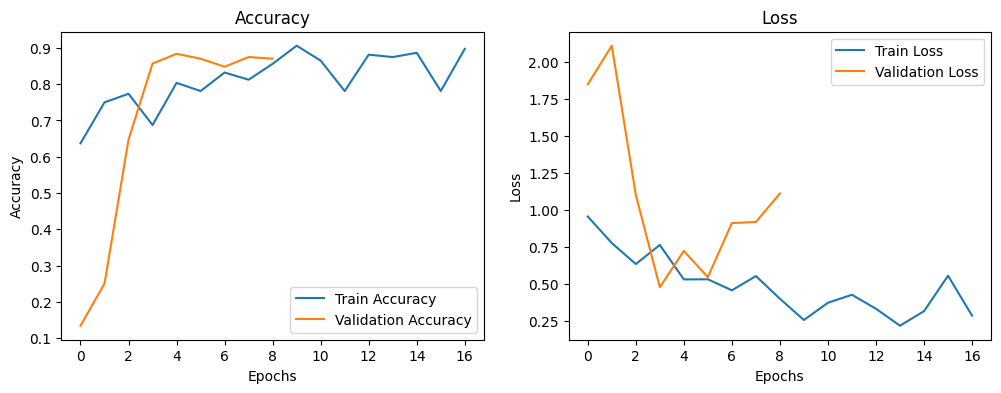

In [8]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


Model Summary

In [9]:
# # Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 107,244,753 (409.11 MB)

 Trainable params: 33,157,381 (126.49 MB)

 Non-trainable params: 7,772,608 (29.65 MB)

 Optimizer params: 66,314,764 (252.97 MB)

In [10]:
# Saving the model
model.save('vgg_resnet_model.h5')

Testing the Model

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [12]:
# Load the saved model
model = load_model(r"E:\jav\vgg_resnet_model.h5", compile=False)

In [13]:
# Load an image for testing
img_path = r"C:\Users\Gnana chandrika\Downloads\fish.jpeg"  # Change the path to your test image
img = image.load_img(img_path, target_size=(img_height, img_width))

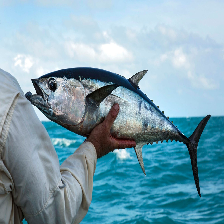

In [14]:
img

In [15]:
# Preprocessing the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Expand dimensions to match the model input shape
x /= 255.0  # Rescale

In [16]:
# Make predictions
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

# Class labels
index = ['vitamin A', 'vitamin B', 'vitamin C', 'vitamin D', 'vitamin E']
result = str(index[pred_class[0]])
print(f'Predicted class: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: vitamin B
